In [1]:
# Make plots of the deviation in treatment vs mortality, stratified for different subcohorts of patients

# those with ventilation on: extract points where mechvent = 1
# those with ventilation off: extract points where mechvent = 0

# Plot variation over time?

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import matplotlib.pyplot as plt

In [3]:
df_orig = pd.read_csv('../data/full_discretised_input_data.csv')
df_orig.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input
0,1,3,7245052800,0,17639.826435,0.0,0,0,1,77.5,...,4,0.0,0.0,3500.0,2100.0,230.0,230.0,3270.0,0.0,4.0
1,2,3,7245067200,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5499.0,1999.0,697.0,467.0,4802.0,0.0,4.0
2,3,3,7245081600,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5604.0,105.0,2302.0,1605.0,3302.0,0.0,2.0
3,4,3,7245096000,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5664.0,60.0,2922.0,620.0,2742.0,0.0,2.0
4,5,3,7245110400,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5724.0,60.0,3352.0,430.0,2372.0,0.0,2.0


In [5]:
df_train = pd.read_csv('../scaled_sets/2lung_train_set_scaled.csv')
df_test = pd.read_csv('../scaled_sets/2lung_test_set_scaled.csv')
df_test.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,14,4264269300,0.0,0.909076,0.153846,0.0,0,1,0.204211,...,0.0,0.0,0.721881,0.893940,0.619692,0.715724,0.516000,0.0,4.0,-0.333333
1,0.222560,14,4264283700,0.0,0.909076,0.153846,0.0,0,1,0.224580,...,0.0,0.0,0.738649,0.761676,0.661037,0.757034,0.517250,0.0,3.0,-0.666667
2,0.356608,14,4264298100,0.0,0.909076,0.153846,0.0,0,1,0.244949,...,0.0,0.0,0.752386,0.761676,0.684312,0.741625,0.519100,0.0,3.0,-1.000000
3,0.452837,14,4264312500,0.0,0.909076,0.153846,0.0,0,1,0.265317,...,0.0,0.0,0.758425,0.696293,0.692923,0.665198,0.520183,0.0,2.0,-1.333333
4,0.527957,14,4264326900,0.0,0.909076,0.153846,0.0,0,1,0.285686,...,0.0,0.0,0.758425,0.000000,0.692923,0.000000,0.520183,0.0,0.0,-1.666667


In [6]:
df_train_orig = df_orig[df_orig['icustayid'].isin(df_train['icustayid'].unique())]
df_test_orig = df_orig[df_orig['icustayid'].isin(df_test['icustayid'].unique())]

In [7]:
#  Extract out the interventions from the training dataset and find the medians for each dosage - these
#  represent the continuous analog of the chosen actions
interventions = df_train_orig[["max_dose_vaso", "input_4hourly_tev"]]
interventions.head()

,max_dose_vaso,input_4hourly_tev
0,0.0,2100.0
1,0.0,1999.0
2,0.0,105.0
3,0.0,60.0
4,0.0,60.0


In [8]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] > 0]
adjusted_iv = interventions["input_4hourly_tev"][interventions["input_4hourly_tev"] > 0]

vaso_vals = [0]
vaso_vals.extend(adjusted_vaso.quantile([0.125,0.375,0.625,0.875]))
iv_vals = [0]
iv_vals.extend(adjusted_iv.quantile([0.125,0.375,0.625,0.875]))

In [9]:
inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = (i,j)
        count += 1 
action_map = {val:key for key, val in inv_action_map.items()}


In [11]:
#  Load the correct phys/agent actions we want in the plots
def f(x):
    return action_map[(x[0], x[1])]
phys_actions = list(df_test_orig[['iv_input', 'vaso_input']].apply(f, axis=1))

deeprl2_actions = pickle.load(open( "../dqn_models/lung_dqn_2/dqn_normal_actions_test.p", "rb" ))

In [12]:
# Add in the actions selected to the df_test_orig dataframe. This helps with the stratified analysis afterwards
df_test_orig['deeprl2_actions'] = deeprl2_actions
df_test_orig['phys_actions'] = phys_actions

/Users/sapnakumari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sapnakumari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Perform stratification based on what we're looking for

# Mechanical Ventilation off 
df_test_orig_vent_off = df_test_orig[df_test_orig['mechvent'] == 0]

# Mechanical VEntilation on
df_test_orig_vent_on = df_test_orig[df_test_orig['mechvent'] == 1]


In [14]:
# Now re-select the phys_actions, and deeprl2_actions based on the statified dataset
deeprl2_actions_vent_off = df_test_orig_vent_off['deeprl2_actions'].values
phys_actions_vent_off = df_test_orig_vent_off['phys_actions'].values

deeprl2_actions_vent_on = df_test_orig_vent_on['deeprl2_actions'].values
phys_actions_vent_on = df_test_orig_vent_on['phys_actions'].values


In [15]:
def get_action_tuples(phys_actions, deeprl_actions):
    phys_actions_tuple =  [None for i in range(len(phys_actions))]
    deeprl_actions_tuple =  [None for i in range(len(deeprl_actions))]
    
    for i in range(len(phys_actions)):
        phys_actions_tuple[i] = inv_action_map[phys_actions[i]]
        deeprl_actions_tuple[i] = inv_action_map[deeprl_actions[i]]

    return np.array(phys_actions_tuple), np.array(deeprl_actions_tuple)

phys_actions_vent_off_tuple, deeprl2_actions_vent_off_tuple = get_action_tuples(phys_actions_vent_off, 
                                                                               deeprl2_actions_vent_off)

phys_actions_vent_on_tuple, deeprl2_actions_vent_on_tuple = get_action_tuples(phys_actions_vent_on, 
                                                                              deeprl2_actions_vent_on)


In [16]:
def get_iv_vaso_hist2d(actions_tuple, num_bins=5):
    actions_iv = actions_tuple[:,0]
    actions_vaso = actions_tuple[:,1]
    hist, x_edges, y_edges = np.histogram2d(actions_iv, actions_vaso, bins=num_bins)
    
    return hist

hist_ph_off = get_iv_vaso_hist2d(phys_actions_vent_off_tuple)
hist_ph_on = get_iv_vaso_hist2d(phys_actions_vent_on_tuple)

hist_dr_off = get_iv_vaso_hist2d(deeprl2_actions_vent_off_tuple)
hist_dr_on = get_iv_vaso_hist2d(deeprl2_actions_vent_on_tuple)

x_edges = np.arange(-0.5,5)
y_edges = np.arange(-0.5,5)

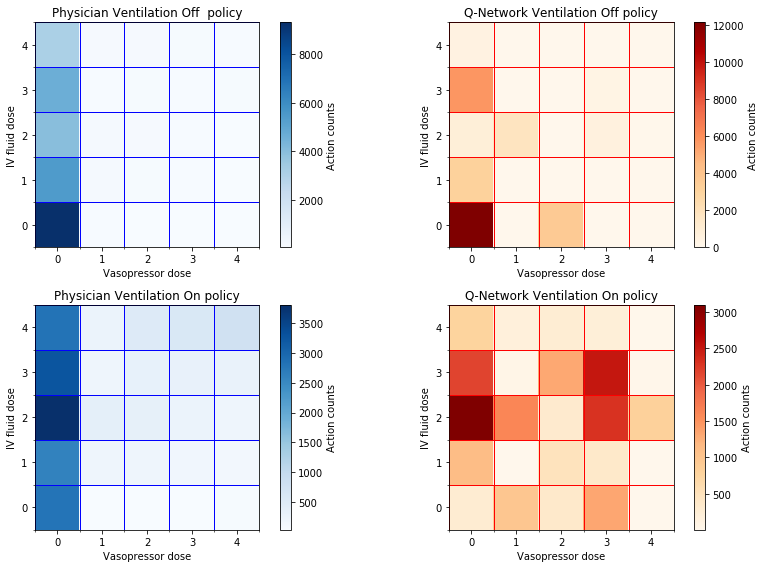

In [31]:
f, axes = plt.subplots(2, 2, figsize=(12,8))
ax1 = axes[0,1]
ax2 = axes[1,1]
ax3 = axes[0,0]
ax4 = axes[1,0]
ax1.imshow(np.flipud(hist_dr_off), cmap="OrRd",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax2.imshow(np.flipud(hist_dr_on), cmap="OrRd", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])

# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));

# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1));
ax1.set_yticklabels(np.arange(0, 5, 1));
ax2.set_xticklabels(np.arange(0, 5, 1));
ax2.set_yticklabels(np.arange(0, 5, 1));


# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='r', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='r', linestyle='-', linewidth=1)

im1 = ax1.pcolormesh(x_edges, y_edges, hist_dr_off, cmap='OrRd')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges, y_edges, hist_dr_on, cmap='OrRd')
f.colorbar(im2, ax=ax2, label = "Action counts")


ax1.set_ylabel('IV fluid dose')
ax2.set_ylabel('IV fluid dose')

ax1.set_xlabel('Vasopressor dose')
ax2.set_xlabel('Vasopressor dose')

ax1.set_title("Q-Network Ventilation Off policy")
ax2.set_title("Q-Network Ventilation On policy")


ax3.imshow(np.flipud(hist_ph_off), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax4.imshow(np.flipud(hist_ph_on), cmap="Blues", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])


# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)

# Major ticks
ax3.set_xticks(np.arange(0, 5, 1));
ax3.set_yticks(np.arange(0, 5, 1));
ax4.set_xticks(np.arange(0, 5, 1));
ax4.set_yticks(np.arange(0, 5, 1));

# Labels for major ticks
ax3.set_xticklabels(np.arange(0, 5, 1));
ax3.set_yticklabels(np.arange(0, 5, 1));
ax4.set_xticklabels(np.arange(0, 5, 1));
ax4.set_yticklabels(np.arange(0, 5, 1));

# Minor ticks
ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax4.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax4.set_yticks(np.arange(-.5, 5, 1), minor=True);


# Gridlines based on minor ticks
ax3.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax4.grid(which='minor', color='b', linestyle='-', linewidth=1)


im1 = ax3.pcolormesh(x_edges, y_edges, hist_ph_off, cmap='Blues')
f.colorbar(im1, ax=ax3, label = "Action counts")

im2 = ax4.pcolormesh(x_edges, y_edges, hist_ph_on, cmap='Blues')
f.colorbar(im2, ax=ax4, label = "Action counts")


ax3.set_ylabel('IV fluid dose')
ax4.set_ylabel('IV fluid dose')
ax3.set_xlabel('Vasopressor dose')
ax4.set_xlabel('Vasopressor dose')


ax3.set_title("Physician Ventilation Off  policy")
ax4.set_title("Physician Ventilation On policy")
plt.tight_layout()
plt.savefig("../plots/lungs/ventilation_phys_dr_actions.png")



In [18]:
def sliding_mean(data_array, window=1):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

In [19]:
def make_df_diff(op_actions, df_in):
    op_vaso_med = []
    op_iv_med = []
    for action in op_actions:
        iv,vaso = inv_action_map[action]
        op_vaso_med.append(vaso_vals[vaso])
        op_iv_med.append(iv_vals[iv])
    iv_diff = np.array(op_iv_med) - np.array(df_in['input_4hourly_tev'])
    vaso_diff = np.array(op_vaso_med) - np.array(df_in['max_dose_vaso'])
    df_diff = pd.DataFrame()
    df_diff['mort'] = np.array(df_in['died_in_hosp'])
    df_diff['iv_diff'] = iv_diff
    df_diff['vaso_diff'] = vaso_diff
    return df_diff

In [20]:
from scipy.stats import sem
def make_iv_plot_data(df_diff):
    bin_medians_iv = []
    mort_iv = []
    mort_std_iv= []
    i = -800
    while i <= 900:
        count =df_diff.loc[(df_diff['iv_diff']>i-50) & (df_diff['iv_diff']<i+50)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_iv.append(i)
                mort_iv.append(res)
                mort_std_iv.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 100
    return bin_medians_iv, mort_iv, mort_std_iv

In [21]:
from scipy.stats import sem
def make_vaso_plot_data(df_diff):
    bin_medians_vaso = []
    mort_vaso= []
    mort_std_vaso= []
    i = -0.6
    while i <= 0.6:
        count =df_diff.loc[(df_diff['vaso_diff']>i-0.05) & (df_diff['vaso_diff']<i+0.05)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_vaso.append(i)
                mort_vaso.append(res)
                mort_std_vaso.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 0.1
    return bin_medians_vaso, mort_vaso, mort_std_vaso

In [22]:
df_diff_low = make_df_diff(deeprl2_actions_low, df_test_orig_low)
df_diff_mid = make_df_diff(deeprl2_actions_mid, df_test_orig_mid)
df_diff_high = make_df_diff(deeprl2_actions_high, df_test_orig_high)

NameError: name 'deeprl2_actions_low' is not defined

In [ ]:
bin_med_iv_deep_low, mort_iv_deep_low, mort_std_iv_deep_low = make_iv_plot_data(df_diff_low)
bin_med_vaso_deep_low, mort_vaso_deep_low, mort_std_vaso_deep_low = make_vaso_plot_data(df_diff_low)

bin_med_iv_deep_mid, mort_iv_deep_mid, mort_std_iv_deep_mid = make_iv_plot_data(df_diff_mid)
bin_med_vaso_deep_mid, mort_vaso_deep_mid, mort_std_vaso_deep_mid = make_vaso_plot_data(df_diff_mid)

bin_med_iv_deep_high, mort_iv_deep_high, mort_std_iv_deep_high = make_iv_plot_data(df_diff_high)
bin_med_vaso_deep_high, mort_vaso_deep_high, mort_std_vaso_deep_high = make_vaso_plot_data(df_diff_high)

In [ ]:
def diff_plot(med_vaso, mort_vaso, std_vaso, med_iv, mort_iv, std_iv, col, title):
    f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (10,4))
    step = 2
    if col == 'r':
        fillcol = 'lightsalmon'
    elif col == 'g':
        fillcol = 'palegreen'
        step = 1
    elif col == 'b':
        fillcol = 'lightblue'
    ax1.plot(med_vaso, sliding_mean(mort_vaso), color=col)
    ax1.fill_between(med_vaso, sliding_mean(mort_vaso) - 1*std_vaso,  
                     sliding_mean(mort_vaso) + 1*std_vaso, color=fillcol)
    t = title + ": Vasopressors"
    ax1.set_title(t)
    x_r = [i/10.0 for i in range(-6,8,2)]

    y_r = [i/20.0 for i in range(0,20,step)]
    ax1.set_xticks(x_r)
    ax1.set_yticks(y_r)
    ax1.grid()

    ax2.plot(med_iv, sliding_mean(mort_iv), color=col)
    ax2.fill_between(med_iv, sliding_mean(mort_iv) - 1*std_iv,  
                     sliding_mean(mort_iv) + 1*std_iv, color=fillcol)
    t = title + ": IV fluids"
    ax2.set_title(t)
    x_iv = [i for i in range(-800,900,400)]
    ax2.set_xticks(x_iv)
    ax2.grid()

#     ax3.plot(bin_med_vaso_auto, sliding_mean(mort_vaso_auto), color='g')
#     ax3.fill_between(bin_med_vaso_auto, sliding_mean(mort_vaso_auto) - 1*mort_std_vaso_auto,  
#                      sliding_mean(mort_vaso_auto) + 1*mort_std_vaso_auto, color='palegreen')
#     y_auto = [i/20.0 for i in range(0,21,1)]
#     ax3.set_yticks(y_auto)
#     ax3.set_title('Q-Network (Shaped Rewards) - Vasopressors')
#     ax3.grid()

#     ax4.plot(bin_med_iv_auto, sliding_mean(mort_iv_auto), color='g')
#     ax4.fill_between(bin_med_iv_auto, sliding_mean(mort_iv_auto) - 1*mort_std_iv_auto,  
#                      sliding_mean(mort_iv_auto) + 1*mort_std_iv_auto, color='palegreen')
#     ax4.set_title('Q-Network (Shaped Rewards) - IV Fluids')
#     ax4.grid()
#     plt.tight_layout()
    f.text(0.3, -0.03, 'Difference between optimal and physician vasopressor dose', ha='center', fontsize=10)
    f.text(0.725, -0.03, 'Difference between optimal and physician IV dose', ha='center', fontsize=10)
    f.text(0.05, 0.5, 'Observed Mortality', va='center', rotation='vertical', fontsize = 10)


In [ ]:
diff_plot(bin_med_vaso_deep_low, mort_vaso_deep_low, mort_std_vaso_deep_low, 
          bin_med_iv_deep_low, mort_iv_deep_low, mort_std_iv_deep_low, 'b', 'Low SOFA')

In [ ]:
diff_plot(bin_med_vaso_deep_mid, mort_vaso_deep_mid, mort_std_vaso_deep_mid, 
          bin_med_iv_deep_mid, mort_iv_deep_mid, mort_std_iv_deep_mid, 'g', 'Medium SOFA')

In [ ]:
diff_plot(bin_med_vaso_deep_high, mort_vaso_deep_high, mort_std_vaso_deep_high, 
          bin_med_iv_deep_high, mort_iv_deep_high, mort_std_iv_deep_high, 'r', 'High SOFA')